In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Emergency alert with tweets

### Dataset

In [2]:
#load data from csv
test_dataset = pd.read_csv('test.csv')
train_dataset = pd.read_csv('train.csv')
train_dataset.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
print('Training data points: %i' % len(train_dataset))
print('Test data points: %i' % len(test_dataset))

Training data points: 7613
Test data points: 3263


#### Emergency vs non-emergency proportion

In [4]:
disaster = train_dataset.loc[train_dataset['target'] == 1]
non_disaster = train_dataset.loc[train_dataset['target'] == 0]
disaster_percent = len(disaster)/len(train_dataset) * 100
non_disaster_percent = len(non_disaster)/len(train_dataset) * 100

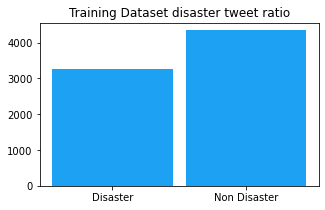

Disaster 42.97%
Non disaster 57.03%


In [5]:
fig = plt.figure(figsize = (5, 3))
plt.bar(['Disaster', 'Non Disaster'], [len(disaster), len(non_disaster)], color ='#1DA1F2', width = 0.9)
plt.title("Training Dataset disaster tweet ratio")
plt.show()
print('Disaster %.2f%%' % disaster_percent)
print('Non disaster %.2f%%' % non_disaster_percent)

### Split the training dataset

In [6]:
# Create train dataframe from 70% of train dataset
disaster_train = train_dataset.sample(frac = 0.7)

# Create development dataframe from 30% of train dataset
disaster_develop = train_dataset.drop(disaster_train.index)

#### Extract data and targets

In [7]:
# get target data vector for train dataset
disaster_train_target = disaster_train.iloc[:,-1:]

# get text vectors for train dataset
disaster_train_data =  disaster_train.loc[:, ["text"]]

# get target data vector for development dataset
disaster_develop_target = disaster_develop.iloc[:,-1:]

#  get text vectors for develop dataset
disaster_develop_data = disaster_develop.loc[:, ["text"]]

disaster_train_data.head()

,text
2190,#KAMINDOZ #reuters Debris confirmed from MH370...
6527,#Autoinsurance industry clueless on driverless...
3273,@carneross indeed and a remarkably puny idea t...
3851,My Gang Walking Round With Them Brown Flames. ...
3527,Aug. 06 2015 Radio Show articles ÛÒ \n1] Eye...


### Preprocessing

In [8]:
import nltk
import re
import unicodedata
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

#### Convert to lowercase

In [9]:
def to_lowercase(text):
    return text.lower()

#### Strip punctuation, accents, special characters and urls

In [10]:
def strip_urls(text):
    return re.sub(r"http\S+", "", text)

In [11]:
def strip_accents(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

In [12]:
def strip_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

#### Strip numbers

In [13]:
def strip_numbers(text):
    regex = r'[^a-zA-z.,!?/:;\"\'\s]' 
    return re.sub(regex, '', text)

#### Tokenize all the words

In [14]:
def tokenize_text(text):    
    return word_tokenize(text)

#### Strip the stop words (e.g., “the”, “and”, “or”)

In [15]:
def strip_stop_words(words):
    stop_words = set(stopwords.words('english'))
    return [w for w in words if w not in stop_words]

#### Lemmatize all the words

In [16]:
def lemmatize_text(words):
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(w,'v') for w in words])

#### Preprocess

In [17]:
def preprocess(data):
    result = data.apply(to_lowercase)
    result = result.apply(strip_urls)
    result = result.apply(strip_accents)
    result = result.apply(strip_punctuation)
    result = result.apply(strip_numbers)
    result = result.apply(tokenize_text)
    result = result.apply(strip_stop_words)
    result = result.apply(lemmatize_text)
    return result

In [18]:
disaster_train_preprocessed = disaster_train_data.apply(preprocess)
disaster_develop_preprocessed = disaster_develop_data.apply(preprocess)
disaster_train_preprocessed.head()

,text
2190,kamindoz reuters debris confirm mh relatives h...
6527,autoinsurance industry clueless driverless car...
3273,carneross indeed remarkably puny idea place ep...
3851,gang walk round brown flame amp thats nd
3527,aug radio show article uo eyewitness account a...


### Bag of Words model

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

#### Create vectors

In [20]:
count_vect = CountVectorizer(min_df=5, binary=True)
X_train = count_vect.fit_transform(disaster_train_preprocessed["text"])
X_develop = count_vect.transform(disaster_develop_preprocessed["text"])
y_train = disaster_train_target["target"]
y_develop = disaster_develop_target["target"]
X_train.shape

(5329, 1804)

### Logistic Regression

In [21]:
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

#### Train (no regularization)

In [22]:
clf_none = LogisticRegression(penalty='none', max_iter=int(1e6))
clf_none.fit(X_train, disaster_train_target["target"])

LogisticRegression(max_iter=1000000, penalty='none')

#### Predict (no regularization)

In [23]:
y_train_predicted = clf_none.predict(X_train)
y_develop_predicted = clf_none.predict(X_develop)

#### Evaluate (no regularization)

In [24]:
cl0_f1_train_score = f1_score(y_train, y_train_predicted)
cl0_f1_develop_score = f1_score(y_develop, y_develop_predicted)
print('F1 score training set: %2f' % cl0_f1_train_score)
print('F1 score development set: %2f' % cl0_f1_develop_score)

F1 score training set: 0.955650
F1 score development set: 0.684395


#### Train (L1)

In [25]:
clf_l1 = linear_model.LogisticRegression(penalty='l1', solver='liblinear',
                                      tol=1e-6, max_iter=int(1e6),
                                      warm_start=True,
                                      intercept_scaling=10000.)
clf_l1.fit(X_train, disaster_train_target["target"])

LogisticRegression(intercept_scaling=10000.0, max_iter=1000000, penalty='l1',
                   solver='liblinear', tol=1e-06, warm_start=True)

#### Predict (L1)

In [26]:
y_train_predicted = clf_l1.predict(X_train)
y_develop_predicted = clf_l1.predict(X_develop)

#### Evaluate (L1)

In [27]:
cl1_f1_train_score = f1_score(y_train, y_train_predicted)
cl1_f1_develop_score = f1_score(y_develop, y_develop_predicted)
print('F1 score training set: %2f' % cl1_f1_train_score)
print('F1 score development set: %2f' % cl1_f1_develop_score)

F1 score training set: 0.833568
F1 score development set: 0.727575


#### Train (L2)

In [28]:
clf_l2 = linear_model.LogisticRegression(max_iter=int(1e6))
clf_l2.fit(X_train, disaster_train_target["target"])

LogisticRegression(max_iter=1000000)

#### Predict (L2)

In [29]:
y_train_predicted = clf_l2.predict(X_train)
y_develop_predicted = clf_l2.predict(X_develop)

#### Evaluate (L2)

In [30]:
cl2_f1_train_score = f1_score(y_train, y_train_predicted)
cl2_f1_develop_score = f1_score(y_develop, y_develop_predicted)
print('F1 score training set: %2f' % cl2_f1_train_score)
print('F1 score development set: %2f' % cl2_f1_develop_score)

F1 score training set: 0.862053
F1 score development set: 0.741971


#### Most relevant words

In [31]:
theta = clf_l1.coef_.flatten()
words = count_vect.get_feature_names()

top_words = pd.DataFrame(zip(words, theta), columns=["word", "theta"])
top_words = top_words.sort_values("theta", ascending=False)
top_words.head(10)

,word,theta
727,hiroshima,3.750712
406,derailment,3.421640
470,earthquake,3.340051
390,debris,3.216067
1460,spill,3.178457
1656,typhoon,2.719141
475,ebola,2.632298
1742,wildfire,2.614553
471,east,2.546805
780,incident,2.469470


Text(0.5, 0, 'Word')

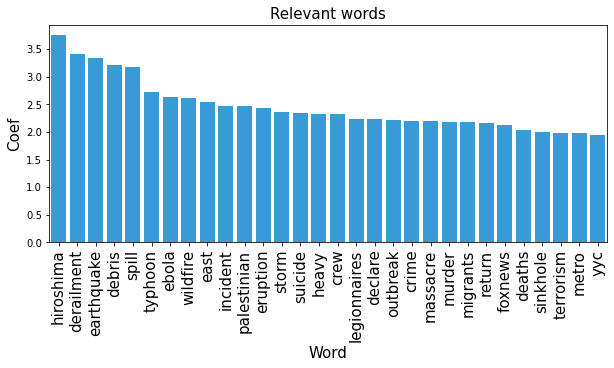

In [32]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.barplot(x="word", y="theta", data=top_words.head(30), palette = sns.color_palette(["#1DA1F2"]))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=15)
ax.set_title("Relevant words", fontsize=15)
ax.set_ylabel("Coef", fontsize=15)
ax.set_xlabel("Word", fontsize=15)

### Bernoulli Naive Bayes

In [33]:
def nb_parameters(x, K):
    n = x.shape[0] # size of the dataset
    d = x.shape[1] # number of features

    psis = np.zeros([K,d])
    phis = np.zeros([K])

    for k in range(K):
        X_k = X_train[y_train == k]
        psis[k] = np.mean(X_k, axis=0)
        phis[k] = X_k.shape[0] / float(n)
        
    return (psis, phis)

In [34]:
def nb_predictions(x, psis, phis, K):
    n, d = x.shape
    x = np.reshape(x, (1, n, d))
    psis = np.reshape(psis, (K, 1, d))
    
    psis = psis.clip(1e-14, 1-1e-14)
    logpy = np.log(phis).reshape([K,1])
    logpxy = x * np.log(psis) + (1-x) * np.log(1-psis)
    logpyx = logpxy.sum(axis=2) + logpy
    return logpyx.argmax(axis=0).flatten(), logpyx.reshape([K,n])

#### Train

In [35]:
psis, phis = nb_parameters(X_train, 2)

#### Predict

In [36]:
y_train_predicted, logpyx_new = nb_predictions(X_train.toarray(), psis, phis, 2)
y_develop_predicted, logpyx_new = nb_predictions(X_develop.toarray(), psis, phis, 2)

#### Evaluate

In [37]:
nb_f1_train_score = f1_score(y_train, y_train_predicted)
nb_f1_develop_score = f1_score(y_develop, y_develop_predicted)
print('F1 score training set: %2f' % nb_f1_train_score)
print('F1 score development set: %2f' % nb_f1_develop_score)

F1 score training set: 0.809042
F1 score development set: 0.744340


### Model comparison

In [38]:
print('Training Set')
print('Logistic Regression (No Regularizer): %2f' % cl0_f1_train_score)
print('Logistic Regression (L1): %2f' % cl1_f1_train_score)
print('Logistic Regression (L2): %2f' % cl2_f1_train_score)
print('Naive Bayes: %2f' % nb_f1_train_score)

print('\nDevelopment Set')
print('Logistic Regression (No Regularizer): %2f' % cl0_f1_develop_score)
print('Logistic Regression (L1): %2f' % cl1_f1_develop_score)
print('Logistic Regression (L2): %2f' % cl2_f1_develop_score)
print('Naive Bayes: %2f' % nb_f1_develop_score)

Training Set
Logistic Regression (No Regularizer): 0.955650
Logistic Regression (L1): 0.833568
Logistic Regression (L2): 0.862053
Naive Bayes: 0.809042

Development Set
Logistic Regression (No Regularizer): 0.684395
Logistic Regression (L1): 0.727575
Logistic Regression (L2): 0.741971
Naive Bayes: 0.744340
